# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernible landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [72]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
import torch
import numpy as np
from torchvision import transforms, datasets
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
import splitfolders
import os.path
from os import path

batch_size = 128
num_workers = 0
valid_ratio = 0.2 # 20% for validation



# laod images using ImageFolder
# Torchvision.datasets.ImageFolder(root: str, transform: Optional[Callable] = None, target_transform: Optional[Callable] = None, loader: Callable[[str], Any] = <function default_loader>, is_valid_file: Optional[Callable[[str], bool]] = None)
train_valid_data = datasets.ImageFolder('landmark_images/train')
# suggested by mentor Tejas J.
#if(not path.exists("landmark_images/train_val/val")):
splitfolders.ratio("landmark_images/train", output="landmark_images/train_val", ratio=(.8, .2), group_prefix=None) #seed=1337
    



# define min width and height
min_width = min_height = np.Inf
for image in train_valid_data:
    if(image[0].size[0]<min_width):
        min_width = image[0].size[0]
    if(image[0].size[1]<min_height):
        min_height = image[0].size[1]
print("min_width: {}    ..    min_height: {}".format(min_width,min_height))
# Resize the images to the lowest power of 2 above min(min_width,min_height) from the images in the training set: 64x64
new_resolution = 1
min_dim = np.min([min_width, min_height])
while (new_resolution*2<min_dim):
    new_resolution*=2
new_resolution*=2
print("new_resolution: ",new_resolution)

# Define transform to resize images and augment dataset
# for training data
resize_augment = transforms.Compose([
    transforms.Resize((new_resolution,new_resolution)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

# for validation data (excludes augmentation)
resize = transforms.Compose([
    transforms.Resize((new_resolution,new_resolution)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

train_data = datasets.ImageFolder("landmark_images/train_val/train", transform = resize_augment)
val_data = datasets.ImageFolder("landmark_images/train_val/val", transform = resize)
test_data = datasets.ImageFolder('landmark_images/test', transform = resize)

# get iterators from data
# DataLoader(dataset, batch_size=1, shuffle=False, sampler=None, batch_sampler=None, num_workers=0, collate_fn=None, pin_memory=False, drop_last=False, timeout=0, worker_init_fn=None, *, prefetch_factor=2, persistent_workers=False)

#train_indices = np.arange(100)


train_loader = DataLoader(train_data, batch_size = batch_size, num_workers = num_workers, shuffle = True)#, sampler=SubsetRandomSampler(train_indices))
valid_loader = DataLoader(train_data, batch_size = batch_size, num_workers = num_workers)
test_loader = DataLoader(test_data, batch_size = batch_size, num_workers = num_workers)

loaders_scratch = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}


min_width: 225    ..    min_height: 60
new_resolution:  64


**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: 
- I resize my images by shrinking them since most of the images are larger in dimension. I chose 64x64 after checking the smallest dimension throughout the images (60) and picking the lowest power of 2 (after 60) to facilitate MaxPooling operations
- I decided to augment the dataset because in my opinion 50 classes for around 5000 images is not enough. I performed random horizontal and vertical flips in addition to random rotations from -20 to 20 degrees (titled camera for example).

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

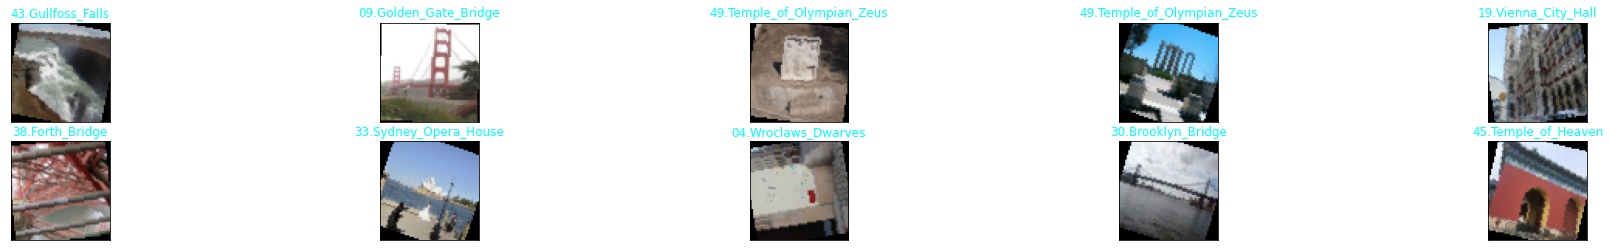

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

## TODO: visualize a batch of the train data loader
batch = iter(train_loader)
images, labels = batch.next()
images = images.numpy()
## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)
classes = train_valid_data.classes
fig = plt.figure(figsize=(32, 4))
for i in range(10):
    ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
    images[i] = images[i]/2 +0.5
    plt.imshow(np.transpose(images[i], (1, 2, 0)))
    ax.set_title(classes[labels[i]], color='cyan')

### Initialize use_cuda variable

In [73]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [74]:
import torch.optim as optim

## TODO: select loss function
criterion_scratch = torch.nn.CrossEntropyLoss()

def get_optimizer_scratch(model):
    ## TODO: select and return an optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    return optimizer
    

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [75]:
import torch.nn as nn
import torch.nn.functional as F
# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(3, 16, kernel_size = 3, stride = 1, padding = 1)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size = 3, stride = 1, padding = 1)
        # maxpool -> 16
        self.conv3 = nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1)
        
        self.conv4 = nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1)
        # maxpool -> 8
        self.conv5 = nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1)
        
        self.conv6 = nn.Conv2d(256, 512, kernel_size = 3, stride = 1, padding = 1)
        # maxpool -> 4
        self.conv7 = nn.Conv2d(512, 1024, kernel_size = 3, stride = 1, padding = 1)
        #self.conv8 = nn.Conv2d(1024, 2048, kernel_size = 3, stride = 1, padding = 1)
        # maxpool -> 2
        
        
        
        '''
        self.pool = nn.MaxPool2d(2,2)
        # dropout
        self.fc1 = nn.Linear(1024*2*2, 1024)
        # dropout
        self.fc2 = nn.Linear(1024, 50)
        # dropout
        #self.fc3 = nn.Linear(2048, 50)
        # dropout
        #self.fc4 = nn.Linear(1024, 50)
        # dropout
        #self.fc5 = nn.Linear(1024, 50)
        self.dropout = nn.Dropout(p = 0.2)
        '''
        
        #classifier test?
        self.pool = nn.MaxPool2d(2,2)
        # dropout
        self.fc1 = nn.Linear(1024*4*4, 8192)
        # dropout
        self.fc2 = nn.Linear(8192, 4096)
        # dropout
        self.fc3 = nn.Linear(4096, 50)
        # dropout
        #self.fc4 = nn.Linear(1024, 50)
        # dropout
        #self.fc5 = nn.Linear(1024, 50)
        self.dropout = nn.Dropout(p = 0.2)
        
        
    def forward(self, x):
        ## Define forward behavior
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))
        x = F.relu(self.conv5(x))
        x = self.pool(F.relu(self.conv6(x)))
        x = self.pool(F.relu(self.conv7(x)))
        #x = self.pool(F.relu(self.conv8(x)))
        
        x = x.view(-1, 1024*4*4)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        #x = self.dropout(x)
        #x = self.fc4(x)
        #x = self.dropout(x)
        #x = self.fc5(x)
        return x

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  
1. I first thought, in cifar we had 10 classes, we could classify the data using 2 convs and 2 fc layers: my intuition was that to classify more classes, we more layers and probably more data.
2. I first tried to have multiple layers (4-5 layers) but the model was not able to learn (training loss not converging)
3. I decided to select a subset of the data (5 batches of 20 to hopefully enough represented classes) and tried to design a model that would overfit on my data.
4. Once the model did overfit, I used the full dataset where I still had an overfitting visible from the first epochs.
5. Reduced both fully connected layers number and also removed 1 convolutional layer.
6. This was done while trying various learning rate, generally 0.01, 0.001 and 0.0001. In some cases, the training wouldn't even converge (so I discarded them fast enough from the first epochs).
7. Then I ran the 20 epochs training to see if it can decrease for 20 epochs which was the case.
8. After that I ran the 100 epochs training for the final model.

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [76]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    train_loss_min = np.Inf
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            optimizer.zero_grad()
            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            output = model(data)
            loss = criterion(output,target)
        
            loss.backward()
            optimizer.step()
            #train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            #train_loss += loss.item()*data.size(0)
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            
            

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 
            output = model(data)
            loss = criterion(output, target)

            #valid_loss += loss.item()*data.size(0)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))
        
        #train_loss /= len(loaders['train'].dataset)
        #valid_loss /= len(loaders['valid'].dataset)
        
        # print training/validation statistics 
        print('Epoch: {}/{} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            n_epochs+1,
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        if (valid_loss < valid_loss_min and train_loss < train_loss_min ):
            print("valid_loss decreased. Saving model...")
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss

    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [12]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.normal_(0, y)
        m.bias.data.fill_(0)
    #if classname.find('Conv2d') != -1:
        #m.weight.data.normal_(0, 0.02)
        #m.bias.data.fill_(0)
        
#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(20, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

Epoch: 1/21 	Training Loss: 3.914259 	Validation Loss: 3.911997
valid_loss decreased. Saving model...
Epoch: 2/21 	Training Loss: 3.898265 	Validation Loss: 3.838120
valid_loss decreased. Saving model...
Epoch: 3/21 	Training Loss: 3.773796 	Validation Loss: 3.669537
valid_loss decreased. Saving model...
Epoch: 4/21 	Training Loss: 3.663430 	Validation Loss: 3.585494
valid_loss decreased. Saving model...
Epoch: 5/21 	Training Loss: 3.570094 	Validation Loss: 3.493333
valid_loss decreased. Saving model...
Epoch: 6/21 	Training Loss: 3.475628 	Validation Loss: 3.417673
valid_loss decreased. Saving model...
Epoch: 7/21 	Training Loss: 3.415068 	Validation Loss: 3.324343
valid_loss decreased. Saving model...
Epoch: 8/21 	Training Loss: 3.358872 	Validation Loss: 3.292701
valid_loss decreased. Saving model...
Epoch: 9/21 	Training Loss: 3.274205 	Validation Loss: 3.212893
valid_loss decreased. Saving model...
Epoch: 10/21 	Training Loss: 3.187893 	Validation Loss: 3.048428
valid_loss decrea

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [13]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 100

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1/101 	Training Loss: 3.913471 	Validation Loss: 3.911699
valid_loss decreased. Saving model...
Epoch: 2/101 	Training Loss: 3.893357 	Validation Loss: 3.834036
valid_loss decreased. Saving model...
Epoch: 3/101 	Training Loss: 3.773211 	Validation Loss: 3.677038
valid_loss decreased. Saving model...
Epoch: 4/101 	Training Loss: 3.677331 	Validation Loss: 3.618367
valid_loss decreased. Saving model...
Epoch: 5/101 	Training Loss: 3.627851 	Validation Loss: 3.545132
valid_loss decreased. Saving model...
Epoch: 6/101 	Training Loss: 3.549048 	Validation Loss: 3.555510
Epoch: 7/101 	Training Loss: 3.509786 	Validation Loss: 3.428394
valid_loss decreased. Saving model...
Epoch: 8/101 	Training Loss: 3.444131 	Validation Loss: 3.392609
valid_loss decreased. Saving model...
Epoch: 9/101 	Training Loss: 3.380333 	Validation Loss: 3.276584
valid_loss decreased. Saving model...
Epoch: 10/101 	Training Loss: 3.291841 	Validation Loss: 3.215513
valid_loss decreased. Saving model...
Epoch: 

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [77]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 7.140431


Test Accuracy: 32% (404/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [14]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
batch_size = 20

vgg_expected_resolution = 224
resize_augment = transforms.Compose([
    transforms.RandomResizedCrop(vgg_expected_resolution),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

# for validation data (excludes augmentation)
resize = transforms.Compose([
    transforms.RandomResizedCrop(vgg_expected_resolution),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

train_data = datasets.ImageFolder("landmark_images/train_val/train", transform = resize_augment)
val_data = datasets.ImageFolder("landmark_images/train_val/val", transform = resize)
test_data = datasets.ImageFolder('landmark_images/test', transform = resize)

# get iterators from data
# DataLoader(dataset, batch_size=1, shuffle=False, sampler=None, batch_sampler=None, num_workers=0, collate_fn=None, pin_memory=False, drop_last=False, timeout=0, worker_init_fn=None, *, prefetch_factor=2, persistent_workers=False)

#train_indices = np.arange(100)


train_loader = DataLoader(train_data, batch_size = batch_size, num_workers = num_workers, shuffle = True)#, sampler=SubsetRandomSampler(train_indices))
valid_loader = DataLoader(train_data, batch_size = batch_size, num_workers = num_workers)
test_loader = DataLoader(test_data, batch_size = batch_size, num_workers = num_workers)
# Using the previous loaders
loaders_transfer = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}




### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [34]:
## TODO: select loss function
import torch.optim as optim 
criterion_transfer = torch.nn.CrossEntropyLoss()


def get_optimizer_transfer(model):
    ## TODO: select and return optimizer
    optimizer = optim.Adam(model.classifier.parameters(), lr = 0.0001)
    return optimizer
    

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [39]:
## TODO: Specify model architecture
from torchvision import models
model_transfer = models.vgg16(pretrained=True)
print(model_transfer)

from collections import OrderedDict

for param in model_transfer.features.parameters():
    param.requires_grad = False

LandmarkClassifier = nn.Sequential(nn.Dropout(p=0.2),
                                   nn.Linear(25088,8192),
                                   nn.ReLU(),
                                   nn.Dropout(p=0.2),
                                   nn.Linear(8192,4096),
                                   nn.ReLU(),
                                   nn.Dropout(p=0.2),
                                   nn.Linear(4096,50))
                    

model_transfer.classifier = LandmarkClassifier
print("=======================================")
print(model_transfer)
#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 
1. I first chose a VGG19 architecture.
2. I checked the inputs of the first layer of the classifier.
3. Replaced the classifier with 3 fully connected layers including a dropout (p=0.2 and p=0.2). 
4. The classifier is the same used from the model created from scratch. I wanted to see specifically the effect of pretrained feature layers on the same fully connected part.

VGG already had great accuracy in image classification tasks. I chose the model because it is not too deep which would make my training time shorter than for e.g. resnet 152).

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [40]:
## TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'
import gc
#del model_scratch
#del loaders_scratch
#del train_data
#del val_data
#del test_data
#del model_transfer
gc.collect()
torch.cuda.empty_cache()
model_transfer = train(200, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer),
                      criterion_transfer, use_cuda, 'model_transfer.pt')    
#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1/201 	Training Loss: 2.742702 	Validation Loss: 1.941744
valid_loss decreased. Saving model...
Epoch: 2/201 	Training Loss: 1.803896 	Validation Loss: 1.576399
valid_loss decreased. Saving model...
Epoch: 3/201 	Training Loss: 1.557404 	Validation Loss: 1.272314
valid_loss decreased. Saving model...
Epoch: 4/201 	Training Loss: 1.373349 	Validation Loss: 1.204489
valid_loss decreased. Saving model...
Epoch: 5/201 	Training Loss: 1.237176 	Validation Loss: 1.089295
valid_loss decreased. Saving model...
Epoch: 6/201 	Training Loss: 1.175055 	Validation Loss: 1.044062
valid_loss decreased. Saving model...
Epoch: 7/201 	Training Loss: 1.078379 	Validation Loss: 0.970850
valid_loss decreased. Saving model...
Epoch: 8/201 	Training Loss: 1.032037 	Validation Loss: 0.901164
valid_loss decreased. Saving model...
Epoch: 9/201 	Training Loss: 0.983799 	Validation Loss: 0.878669
valid_loss decreased. Saving model...
Epoch: 10/201 	Training Loss: 0.945705 	Validation Loss: 0.810003
valid_l

KeyboardInterrupt: 

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [41]:
model_transfer.load_state_dict(torch.load('model_transfer.pt'))
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.252414


Test Accuracy: 73% (913/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [104]:
import cv2
from PIL import Image
## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

# from course to load an image and convert it to a tensor
def load_image(img_path, max_size=vgg_expected_resolution, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')
    
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize((size,size)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image


def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    img = load_image(img_path)
    if (use_cuda):
        img = img.cuda()
    model_transfer.eval()
    predictions = model_transfer(img)
    return torch.topk(predictions,k, dim=1)
# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

torch.return_types.topk(
values=tensor([[20.0964, 18.1225, 11.0349,  4.8997,  1.2809]], device='cuda:0',
       grad_fn=<TopkBackward>),
indices=tensor([[ 9, 38, 30, 33, 28]], device='cuda:0'))

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

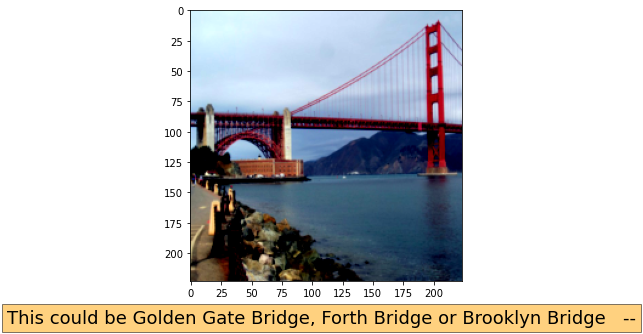

In [105]:
import matplotlib.pyplot as plt
%matplotlib inline

# from course to convert image to the expected input
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.485, 0.456, 0.406)) + np.array((0.229, 0.224, 0.225))
    image = image.clip(0, 1)

    return image

def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks, indices = predict_landmarks(img_path, 3)
    
    ## TODO: display image and display landmark predictions
    text='This could be '
    for i in range(len(indices[0])):
        text+=classes[indices[0][i]][3:] 
        if (i < len(indices[0])-2):
            text += ', '
        elif (i < len(indices[0])-1):
            text += ' or '
        #print(classes[index])
    text = text.replace('_', ' ')    
    # display the images
    fig, ax1 = plt.subplots(1, 1, figsize=(5, 5))
    # content and style ims side-by-side
    plt.figtext(0.5, 0.01,text+ "   -"+img_path.split('/')[1][:-4]+"-", ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
    ax1.imshow(im_convert(load_image(img_path)))
    
# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)
Possible improvements can be:
1. Adding more data. There are only 100 image per landmark.
2. Cleaning some data. Some images are very generic and has no relation to the landmark. e.g. : `landmark_images/train/08.Grand_Canyon/462413d576ee7ded.jpg`
3. Higher resolution images could help achieve better performance: I tried 32x32 and 64x64. There were some differences noticed. But this requires more hardware resources for faster training times.
3. Use a deeper network such as resnet 50.

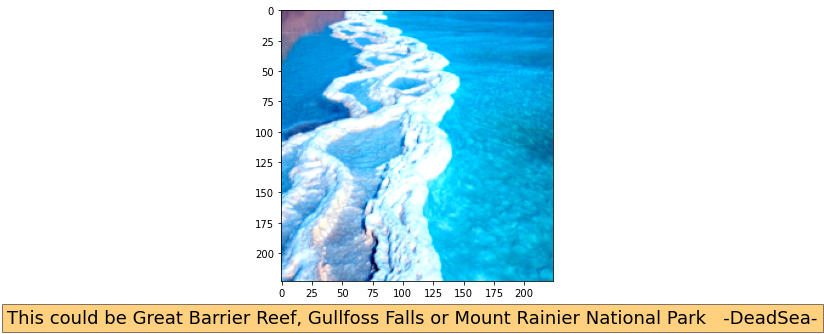

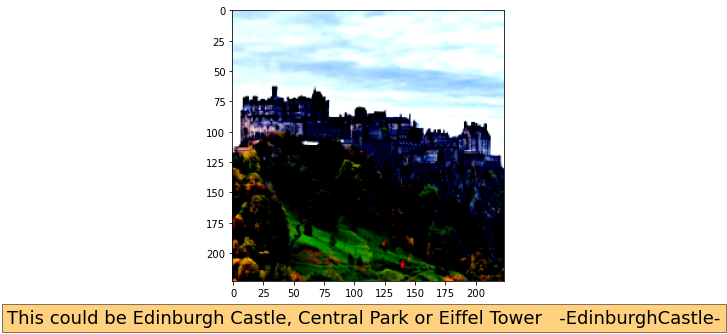

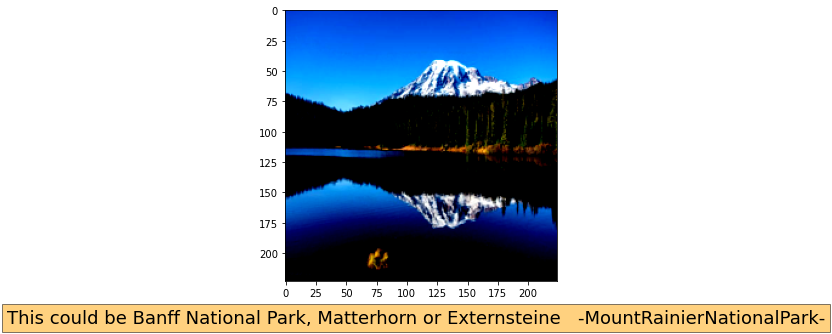

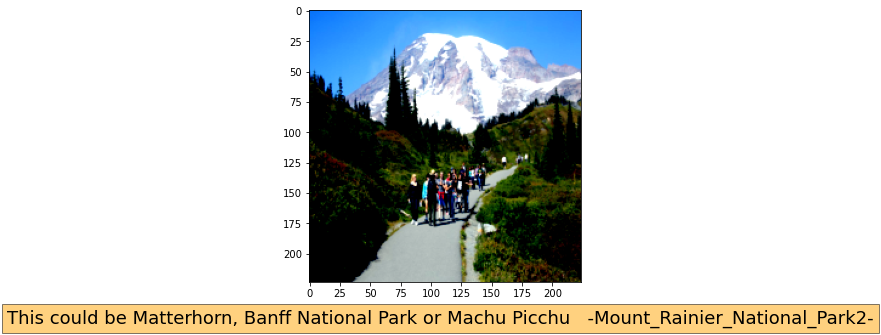

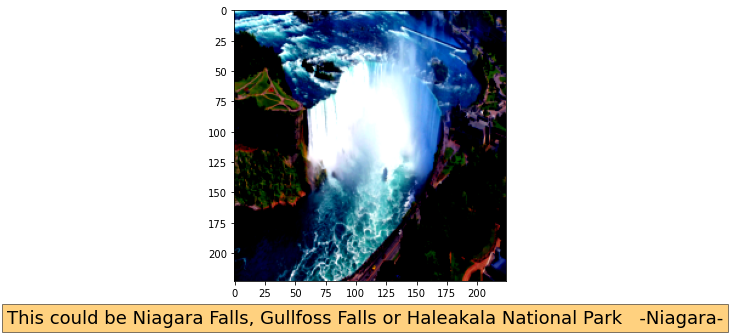

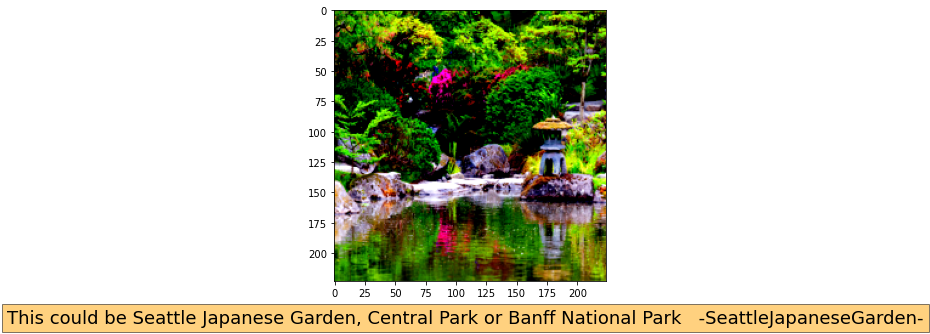

In [106]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.
import os

# Collect paths from root folder
img_paths = []
root = "test_images/"
for _, _, files in os.walk(root):
    for filename in files:
        path = root + filename
        img_paths.append(path)

# use previously detected
for img in img_paths:
    suggest_locations(img)
